In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import statsmodels.api as sm
import scipy.stats as stats

import yfinance as yf

In [5]:
# Define the ticker symbol for Apple
ticker = 'AAPL'

# Get the data of the stock
data = yf.download(ticker, start="2020-01-01", )
print(data.shape)

[*********************100%***********************]  1 of 1 completed

(1222, 6)


In [6]:
data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2020-01-02 00:00:00+00:00,72.876099,75.087502,75.150002,73.797501,74.059998,135480400
2020-01-03 00:00:00+00:00,72.167618,74.357498,75.144997,74.125000,74.287498,146322800
2020-01-06 00:00:00+00:00,72.742676,74.949997,74.989998,73.187500,73.447502,118387200
2020-01-07 00:00:00+00:00,72.400551,74.597504,75.224998,74.370003,74.959999,108872000
2020-01-08 00:00:00+00:00,73.565216,75.797501,76.110001,74.290001,74.290001,132079200


### PCA weights from a risk distribution R

In [7]:
def pcaWeights(cov, riskDist=None, riskTarget=1.):
    eVal, eVec = np.linalg.eig(cov)
    indices = eVal.argsort()[::-1]
    eVal, eVec = eVal[indices], eVec[:, indices]
    if riskDist is None:
        riskDist = np.zeros(cov.shape[0])
        riskDist[-1] = 1
    loads = riskTarget * (riskDist/eVal)**.5
    wghts = np.dot(eVec, loads.reshape(-1, 1))
    return wghts

In [8]:
matrixSize = 3 
np.random.seed(0)
A = np.random.rand(matrixSize, matrixSize)
B = np.dot(A, A.transpose())
pcaWeights(B)

array([[ 4.91041938],
       [-3.132718  ],
       [-1.73855105]])

#### The symmetric CUSUM Filter

In [9]:
def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    diff = gRaw.diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos + diff.loc[i].values[0]), min(0, sNeg + diff.loc[i].values[0])
        if sPos > h:
            sPos = 0
            tEvents.append(i)
        if sNeg < -h:
            sNeg = 0
            tEvents.append(i)
    return tEvents

In [10]:
prices = data['Close']
events = getTEvents(prices, 5)

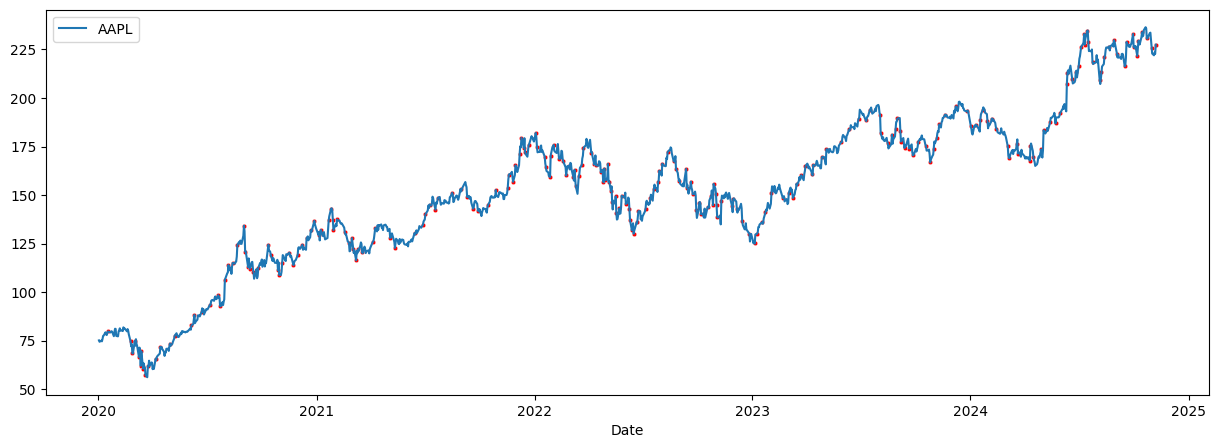

In [11]:
plt.figure(figsize=(15,5))
sns.lineplot(data['Close'])
sns.scatterplot(x=pd.Series(events),y=data.loc[events,'Close'].values.reshape(-1), s=10, color="red")
plt.show()

## Exercise

In [12]:
## get the data
es_data = yf.download("ES=F", start='2022-11-11', interval="1h") 
print(es_data.shape)

[*********************100%***********************]  1 of 1 completed

(11405, 6)


In [13]:
es_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,ES=F,ES=F,ES=F,ES=F,ES=F,ES=F
Datetime,,,,,,
2022-11-11 05:00:00+00:00,3984.5,3984.5,3985.25,3966.00,3969.25,0
2022-11-11 06:00:00+00:00,3988.5,3988.5,3990.75,3981.50,3984.50,17131
2022-11-11 07:00:00+00:00,3994.0,3994.0,3995.00,3981.75,3988.50,19194
2022-11-11 08:00:00+00:00,3995.5,3995.5,3997.50,3981.00,3994.00,34204
2022-11-11 09:00:00+00:00,3984.0,3984.0,3995.75,3979.25,3995.75,31928


In [14]:
es_data.columns = es_data.columns.get_level_values(0)

In [15]:
es_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Datetime,,,,,,
2022-11-11 05:00:00+00:00,3984.5,3984.5,3985.25,3966.00,3969.25,0
2022-11-11 06:00:00+00:00,3988.5,3988.5,3990.75,3981.50,3984.50,17131
2022-11-11 07:00:00+00:00,3994.0,3994.0,3995.00,3981.75,3988.50,19194
2022-11-11 08:00:00+00:00,3995.5,3995.5,3997.50,3981.00,3994.00,34204
2022-11-11 09:00:00+00:00,3984.0,3984.0,3995.75,3979.25,3995.75,31928


In [16]:
def advanced_bars(series, h, bar_type = 'Volume'):
    index_name = es_data.index.name
    df = pd.DataFrame()
    temp_data = series.reset_index()
    current_vol = 0
    for i in range(len(temp_data)):
        if current_vol == 0:
                date, cum_high,cum_low,cum_open,cum_close,cum_adj_close = temp_data.iloc[i][index_name],temp_data.iloc[i]['High'],temp_data.iloc[i]['Low'],temp_data.iloc[i]['Open'],temp_data.iloc[i]['Close'],temp_data.iloc[i]['Adj Close']
        cum_high, cum_low = max(cum_high, temp_data.iloc[i]['High']), min(cum_low, temp_data.iloc[i]['Low'])
        if bar_type == 'Volume':
            current_vol += temp_data.iloc[i]['Volume']
        elif bar_type == 'Dollar':
            current_vol += temp_data.iloc[i]['Volume'] * temp_data.iloc[i]['Close']
        elif bar_type == 'Tick':
            current_vol += 1
        else:
            raise ValueError("bar_type Wrong! Please enter correct bar_type: Volume, Dollar or Tick")

        if (current_vol >= h):
            cum_close = temp_data.iloc[i][ 'Close']
            cum_adj_close = temp_data.iloc[i]['Adj Close']
            temp = pd.DataFrame([[date, cum_adj_close, cum_close, cum_high, cum_low, cum_open, current_vol]], columns = [index_name,'Adj Close','Close','High','Low','Open','Cum '+bar_type])
            current_vol = 0
            df = pd.concat([df, temp], axis=0)
    df.set_index(index_name, inplace=True)
    return df

In [17]:
tick_bars = advanced_bars(es_data, h=2, bar_type='Tick')
tick_bars.shape

(5702, 6)

In [18]:
volume_bars = advanced_bars(es_data, h=20000, bar_type='Volume')
volume_bars.shape

(6800, 6)

In [19]:
dollar_bars = advanced_bars(es_data, h=20000*5000, bar_type='Dollar')
dollar_bars.shape

(6687, 6)

In [20]:
tick_bars

,Adj Close,Close,High,Low,Open,Cum Tick
Datetime,,,,,,
2022-11-11 05:00:00+00:00,3988.50,3988.50,3990.75,3966.00,3969.25,2
2022-11-11 07:00:00+00:00,3995.50,3995.50,3997.50,3981.00,3988.50,2
2022-11-11 09:00:00+00:00,3976.50,3976.50,3995.75,3974.75,3995.75,2
2022-11-11 11:00:00+00:00,3980.75,3980.75,3983.25,3972.75,3976.75,2
2022-11-11 13:00:00+00:00,3967.25,3967.25,3984.50,3951.00,3981.00,2
...,...,...,...,...,...,...
2024-11-08 01:00:00+00:00,6001.50,6001.50,6007.00,6001.25,6004.00,2
2024-11-08 03:00:00+00:00,6003.00,6003.00,6005.25,6001.50,6001.50,2
2024-11-08 05:00:00+00:00,6005.00,6005.00,6009.75,6002.75,6003.00,2


In [21]:
tick_counts = tick_bars.resample('W-MON')['Close'].count()
dollar_counts = dollar_bars.resample('W-MON')['Close'].count()
volume_counts = volume_bars.resample('W-MON')['Close'].count()

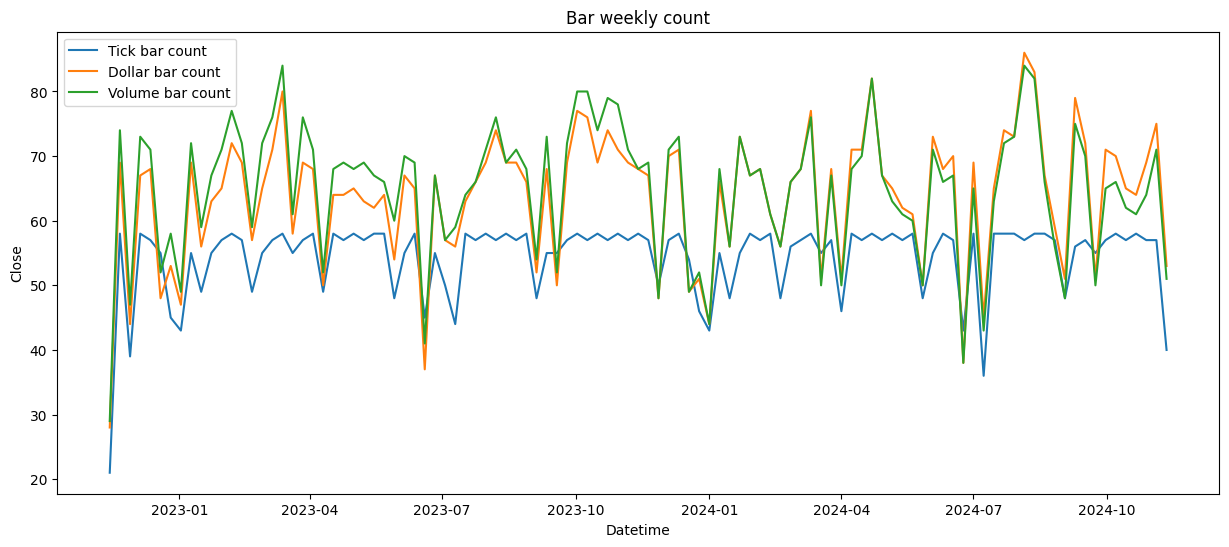

In [22]:
plt.figure(figsize=(15, 6))
sns.lineplot(tick_counts, label='Tick bar count')
sns.lineplot(dollar_counts, label = 'Dollar bar count')
sns.lineplot(volume_counts, label = 'Volume bar count')
plt.title("Bar weekly count")
plt.show()

In [23]:
count_df = pd.DataFrame(columns = ['count_mean', 'count_std'], index=['tick', 'volume', 'dollar'])
count_df.loc['tick'] = [tick_counts.mean(), tick_counts.std()]
count_df.loc['volume'] = [volume_counts.mean(), volume_counts.std()]
count_df.loc['dollar'] = [dollar_counts.mean(), dollar_counts.std()]
count_df

,count_mean,count_std
tick,54.304762,6.006605
volume,64.761905,10.551635
dollar,63.685714,10.32204


In [24]:
def returns(s):
    arr = np.diff(np.log(s))
    return pd.Series(arr, index=s.index[1:])

In [ ]:
def get_test_stats(bar_types,bar_returns,test_func,*args,**kwds):
    dct = {bar:(int(bar_ret.shape[0]), test_func(bar_ret,*args,**kwds)) for bar,bar_ret in zip(bar_types,bar_returns)}
    df = (pd.DataFrame.from_dict(dct).rename(index={0:'sample_size',1:f'{test_func.__name__}_stat'}).T)
    return df

In [41]:
tick_returns = returns(tick_bars['Close'])
volume_returns = returns(volume_bars['Close'])
dollar_returns = returns(dollar_bars['Close'])
df_returns = returns(es_data['Close'])
bar_types = ['tick','volume','dollar','df']
bar_returns = [tick_returns, volume_returns, dollar_returns, df_returns]
pd.DataFrame([tick_returns.autocorr(), volume_returns.autocorr(), dollar_returns.autocorr(), df_returns.autocorr()], columns=['returns_corr'], index=['tick', 'volume', 'dollar', 'df'])

,returns_corr
tick,-0.001383
volume,0.026846
dollar,0.029658
df,0.018797


In [26]:
def partition_monthly(s):
    return s.resample("1ME").var()

In [37]:
tick_monthly = partition_monthly(tick_returns)
volume_monthly = partition_monthly(volume_returns)
dollar_monthly = partition_monthly(dollar_returns)
df_monthly = partition_monthly(df_returns)
monthly_vars = [tick_monthly, volume_monthly, dollar_monthly, df_monthly]
get_test_stats(bar_types, monthly_vars, np.var).sort_values(by='var_stat')

,sample_size,var_stat
df,25.0,2.750570e-12
volume,25.0,6.806595e-12
dollar,25.0,7.923350e-12
tick,25.0,1.279283e-11


In [30]:
print(tick_monthly.var())
print(volume_monthly.var())
print(dollar_monthly.var())

1.3325863355139343e-11
7.090203171439835e-12
8.253489203444516e-12


In [70]:
def jb(x, test=True):
    np.random.seed(12)
    if test:
        return stats.jarque_bera(x)[0]
    return stats.jarque_bera(x)[1]

get_test_stats(bar_types,bar_returns,jb).sort_values('jb_stat')

,sample_size,jb_stat
dollar,6686.0,10546.070992
volume,6799.0,10708.875448
tick,5701.0,19636.789713
df,11404.0,68559.264755


In [71]:
def shapiro(x,test=True): 
    np.random.seed(12345678)
    if test: return stats.shapiro(x)[0]
    return stats.shapiro(x)[1]

get_test_stats(bar_types,bar_returns,shapiro).sort_values('shapiro_stat')[::-1]

/home/zhi/miniconda3/envs/finance/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5701.
  res = hypotest_fun_out(*samples, **kwds)
/home/zhi/miniconda3/envs/finance/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6799.
  res = hypotest_fun_out(*samples, **kwds)
/home/zhi/miniconda3/envs/finance/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6686.
  res = hypotest_fun_out(*samples, **kwds)
/home/zhi/miniconda3/envs/finance/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11404.
  res = hypotest_fun_out(*samples, **kwds)


,sample_size,shapiro_stat
volume,6799.0,0.935610
dollar,6686.0,0.934943
tick,5701.0,0.875001
df,11404.0,0.862897


#### Imbance bars

In [73]:
ib_data = es_data.copy()

In [77]:
ib_data['b'] = 1
ib_data['Close_diff'] = ib_data['Close'].diff()
ib_data['b'] = np.where(ib_data['Close_diff'] != 0, ib_data['Close_diff']/ib_data['Close_diff'], np.nan)
ib_data['b'] = ib_data['b'].ffill()